In [340]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot
import util

plt.style.use("ggplot")

In [341]:
# Given data

# Nissan leaf
# Gravity
g = 9.81  # m/s2
# Vehicle mass
m = 1654  # kg
# Motor inertia Moment
j_m = 0  # kgm2 Hp
# Wheel inertia moment
j_w = 0  # kgm2 Hp
# Wheel radius
r_w = 0.315  # m

# Motor
# Rated Torque
t_m_r = 254  # Nm
# Rated Power
p_m_r = 80 * 1000  # W
# Transmission ratio
tau_g = 1 / 8.19
# Transmission Efficiency
eta_d = 0.97
# Transmission reverse efficiency
eta_r = 0.95

# Davis Eq.
# Rolling Resistance
A = 133.3  # N
# Rotational Losses
B = 0.7094  # Ns/m
# Drag
C = 0.491  # Ns2/m2

# Friction and Confort Limits
# Friction Coefficient
mu = 0.8
# Longitudinal acceleration
a_max_i = 1.5  # m/s2
# Lateral acceleration
a_max_t = 1.5  # m/s2

# Driving cicle - Reference speed
V1: float = float(70.0 / 3.6)
V2: float = float(130.0 / 3.6)
V3: float = float(50.0 / 3.6)
V4: float = float(2.0 / 3.6)

In [342]:
w_m_r = util.rated_nominal_speed(p_m_r, t_m_r)

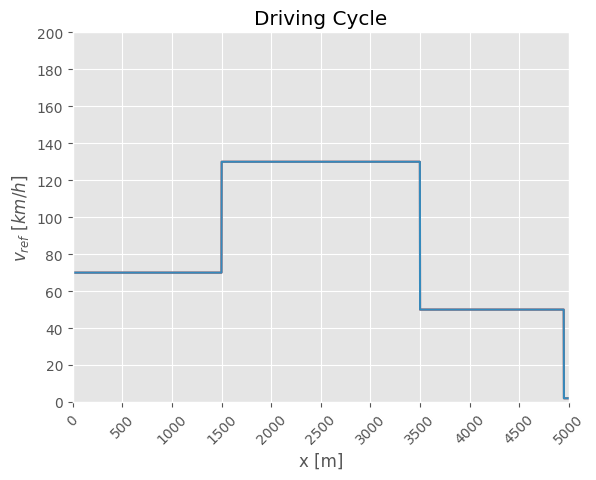

In [343]:
# Reference driving cicle profile

# Longitudinal x profile
x_vals = np.arange(0, 5000, 1)  # m

v_vals = np.piecewise(
    x_vals.astype(np.float64),
    [
        (x_vals >= 0) & (x_vals < 1500),
        (x_vals >= 1500) & (x_vals < 3500),
        (x_vals >= 3500) & (x_vals < 4950),
        (x_vals >= 4950) & (x_vals < 5000),
    ],
    [V1, V2, V3, V4],
).astype(np.float64)
# BE CAREFUL: when using piecewise, numpy was using the dtype of x_vals as a reference to infer the output dtype array.
# Since x_vals was an int64 numpy were trying to preserve this dtype in the output as well.

fig, ax = plt.subplots()
ax.plot(x_vals, v_vals * 3.6)

ax.set(
    title="Driving Cycle",
    xlabel=r"x [m]",
    ylabel=r"$v_{ref}\ [km/h]$",
    xticks=np.arange(0, 5001, 500),
    yticks=np.arange(0, 201, 20),
    ylim=(0, 200),
    xlim=(0, 5000),
)
plt.xticks(rotation=45)
plt.grid(True)

plt.plot(x_vals, v_vals * 3.6)

plt.show()

In [344]:
def get_next_section_params(x: float) -> tuple[float, float]: # return tuple [next_speed, x]
    if x < 0:
        return V1, 0.0  # Assume starts with v1 even if x < 0
    elif x < 1500:
        return V2, 1500.0
    elif x < 3500:
        return V3, 3500.0
    elif x < 4950:
        return V4, 4950.0
    elif x < 5000:
        return V4, 4950.0  # End of profile, no next section — return last speed
    else:
        raise ValueError("x is out of range (must be < 5000)")


# Test
x = 3000
next_v, next_x = get_next_section_params(x)
print(f"Next section starts at x={next_x} m with speed = {next_v:.2f} km/h")

Next section starts at x=3500.0 m with speed = 13.89 km/h


In [345]:
b_d = util.braking_distance(130/3.6, 50/3.6, -1.5)
b_d

370.37037037037027

In [346]:
def get_acceleration(
    current_v: float,
    a_max: float, # comfort
    w_m_r: float,
    t_m_r: float,
    p_m_r: float,
) -> float:
    # Apply traction: positive motor toque
    # v -> angular speed
    w_m = current_v / (r_w * tau_g) 
    # Available torque
    t_m = util.constant_torque_mode(w_m, w_m_r, t_m_r, p_m_r)
    # Motor force
    f_m = (eta_d * t_m) / (r_w * tau_g)
    # Adhesion force
    f_f = util.friction_force(0, m, g, mu, current_v, 2, 4)
    # Max force
    f_max = min(f_m, f_f)
    # Resistance forces
    f_r = util.gradient_force(0, A, B, C, current_v, m, g)
    # acceleration
    acc = (f_max - f_r) / (m + eta_d * j_m / ((r_w * tau_g) ** 2) + 4 * j_w / (r_w**2))

    return min(acc, a_max)


def get_braking_acceleration(
    current_v: float,
    a_max: float, # comfort
    w_m_r: float,
    t_m_r: float,
    p_m_r: float,
) -> float:
    # Apply braking positive motor torque
    # v -> angular speed
    w_m = current_v / (r_w * tau_g) 
    # Available torque
    t_m = util.constant_torque_mode(w_m, w_m_r, t_m_r, p_m_r)
    # Motor force
    f_m = (t_m) / (r_w * tau_g) # braking
    # Adhesion force
    f_ad = util.friction_force(0, m, g, mu, current_v, 2, 4)
    # Max torque possible
    f_max = min(f_m, f_ad)
    # Resistance forces
    f_r = util.gradient_force(0, A, B, C, current_v, m, g)
    # acceleration
    acc =  (f_max - eta_r * f_r) / (eta_r * m  + j_m / ((r_w * tau_g) ** 2) + eta_r * j_w / (r_w ** 2))
    
    return -1.5 # max(- acc, - a_max)

In [359]:
calc_x: list[float] = list()
calc_v: list[float] = list()
calc_a: list[float] = list()
calc_p: list[float] = list()
calc_t: list[float] = list()
calc_v_ref: list[float] = list()
v: float = 0.1
x: float = 0.0
t: float = 0.0
dt: float = 0.1
mode: str = None
braking_flag: bool = False

while True:
    # Break loop
    if x >= 5000:
        break
    # Get the reference values
    v_ref = v_vals[int(x)]
    next_v_ref, next_x_start = get_next_section_params(x)
    
    # If current speed is higher than the next reference speed
    # AND if not breaking
    # Then brake will be needed at some point
    if v > next_v_ref and not braking_flag:
        # Calculate braking distance
        d_braking = util.braking_distance(v, next_v_ref, - a_max_i)
        # If current pos plus braking distance is exceeding the next speed reduce point
        if x + d_braking >= next_x_start:
            # Activate brakes
            braking_flag = True

    # If braking is needed, change mode to brake
    if braking_flag:
        mode = 'b' # Brake
        # If expected speed reached, no more brake needed
        if abs(v - v_ref) <= 0.2:
            braking_flag = False
    elif v < v_ref - 0.2:
        mode = 't' # forward traction
    elif abs(v - v_ref) <= 0.2: # Tolerance
        mode = 'cs' # constant speed
    # else:
    #     # note: Is coasting the same as constant speed?
    #     mode = 'c' # coasting
    
    # Apply control law
    if mode == 'b':
        acc = get_braking_acceleration(v, a_max_i, w_m_r, t_m_r, p_m_r)
    elif mode == 't':
        acc = get_acceleration(v, a_max_i, w_m_r, t_m_r, p_m_r)
    elif mode == 'cs':
        acc = 0
        
    # print(f'{x:.2f}, {mode}, {braking_flag}, d_b: {d_braking:.2f}, x + db: {(x + d_braking):.2f}, next: {next_x_start:.2f}, v: {v:.2f}, v - v_r: {(v - v_ref):.2f}, v:ref:{v_ref:.2f}')
    
    # Calculate speed
    v += acc * dt
    
    # Calculate x
    x += v * dt
    
    # Calculate t
    t += dt
    
    # Calculated power
    # v -> angular speed
    w_m = v / (r_w * tau_g) 
    p = util.constant_power_mode(w_m, w_m_r, t_m_r, p_m_r)
    
    # Append values to lists
    calc_x.append(x)
    calc_v.append(v)
    calc_a.append(acc)
    calc_p.append(p)
    calc_t.append(t)
    calc_v_ref.append(v_ref)

# Convert list to numpy array
calc_x = np.array(calc_x)
calc_v = np.array(calc_v)
calc_a = np.array(calc_a)
calc_p = np.array(calc_p)
calc_p = np.array(calc_t)
calc_v_ref = np.array(calc_v_ref)


# problem 1: in the final section True for x + d_braking >= next_x_start:

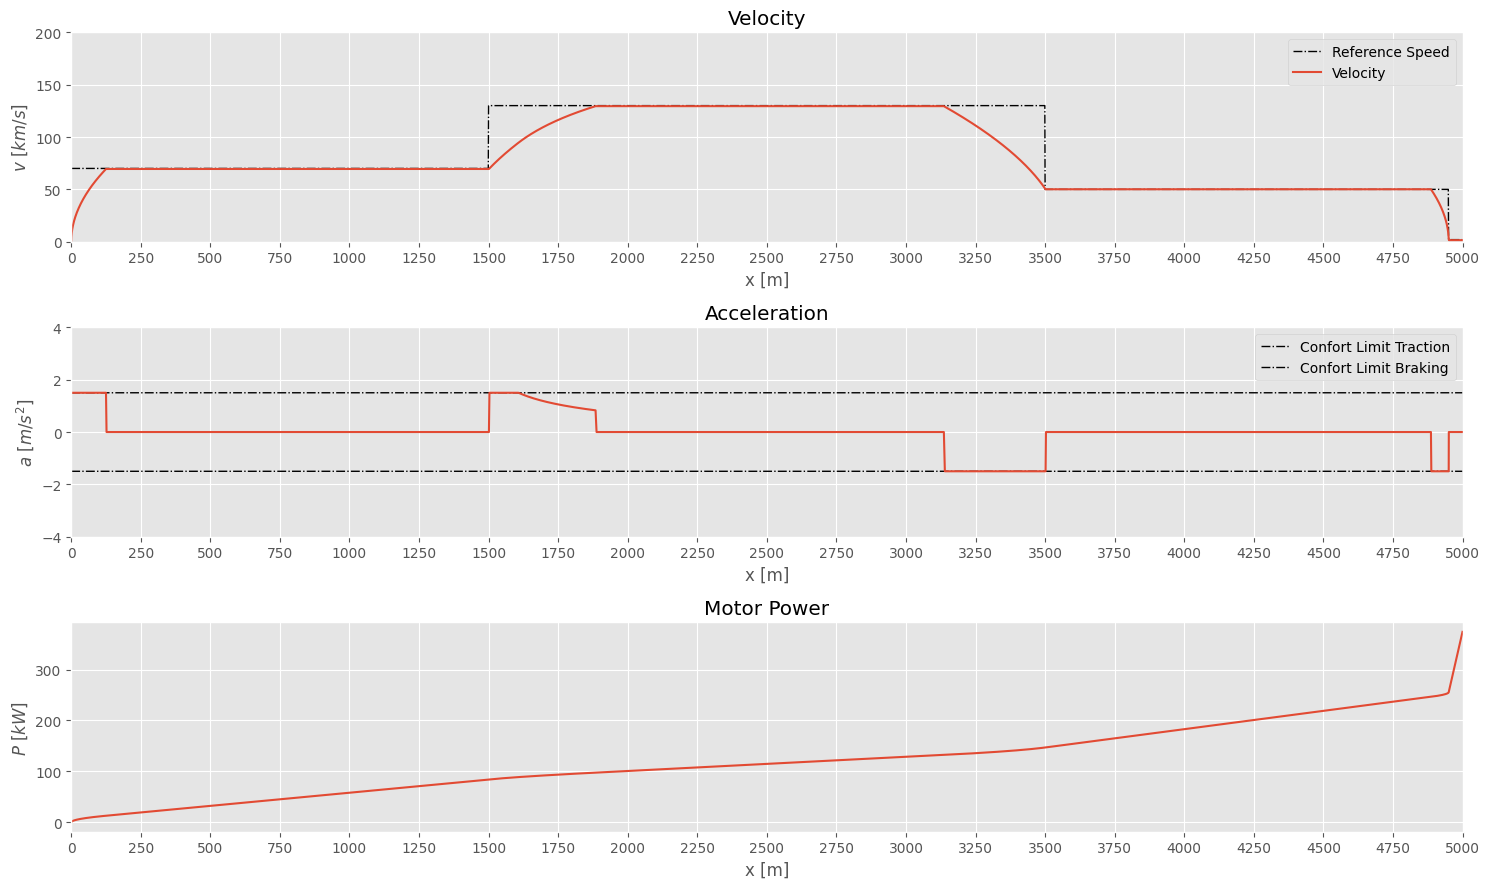

In [366]:
# Plot in x domain 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9))

ax1.plot(x_vals, v_vals * 3.6, color='black', linestyle='-.', linewidth=1, label='Reference Speed')
ax1.plot(calc_x, calc_v * 3.6, label='Velocity')
ax1.set(
    title='Velocity',
    xlabel=r'x [m]',
    ylabel=r'$v\ [km/s]$',
    ylim=(0, 200),
)
ax1.legend(loc='upper right')

ax2.plot(x_vals, np.full(len(x_vals), 1.5), color='black', linestyle='-.', linewidth=1, label='Confort Limit Traction')
ax2.plot(x_vals, np.full(len(x_vals), -1.5), color='black', linestyle='-.', linewidth=1, label='Confort Limit Braking')
ax2.plot(calc_x, calc_a)
ax2.set(
    title='Acceleration',
    xlabel=r'x [m]',
    ylabel=r'$a\ [m/s^2]$',
    ylim=(-4, 4),
)
ax2.legend(loc='upper right')

ax3.plot(calc_x, calc_p)
ax3.set(
    title='Motor Power',
    xlabel=r'x [m]',
    ylabel=r'$P\ [kW]$',

)
#ax3.legend(loc='upper right')


for ax in fig.get_axes():
    ax.set(
        xlim=(0, 5000),
        xticks=np.arange(0, 5001, 250),
    )
plt.tight_layout()

plt.show()

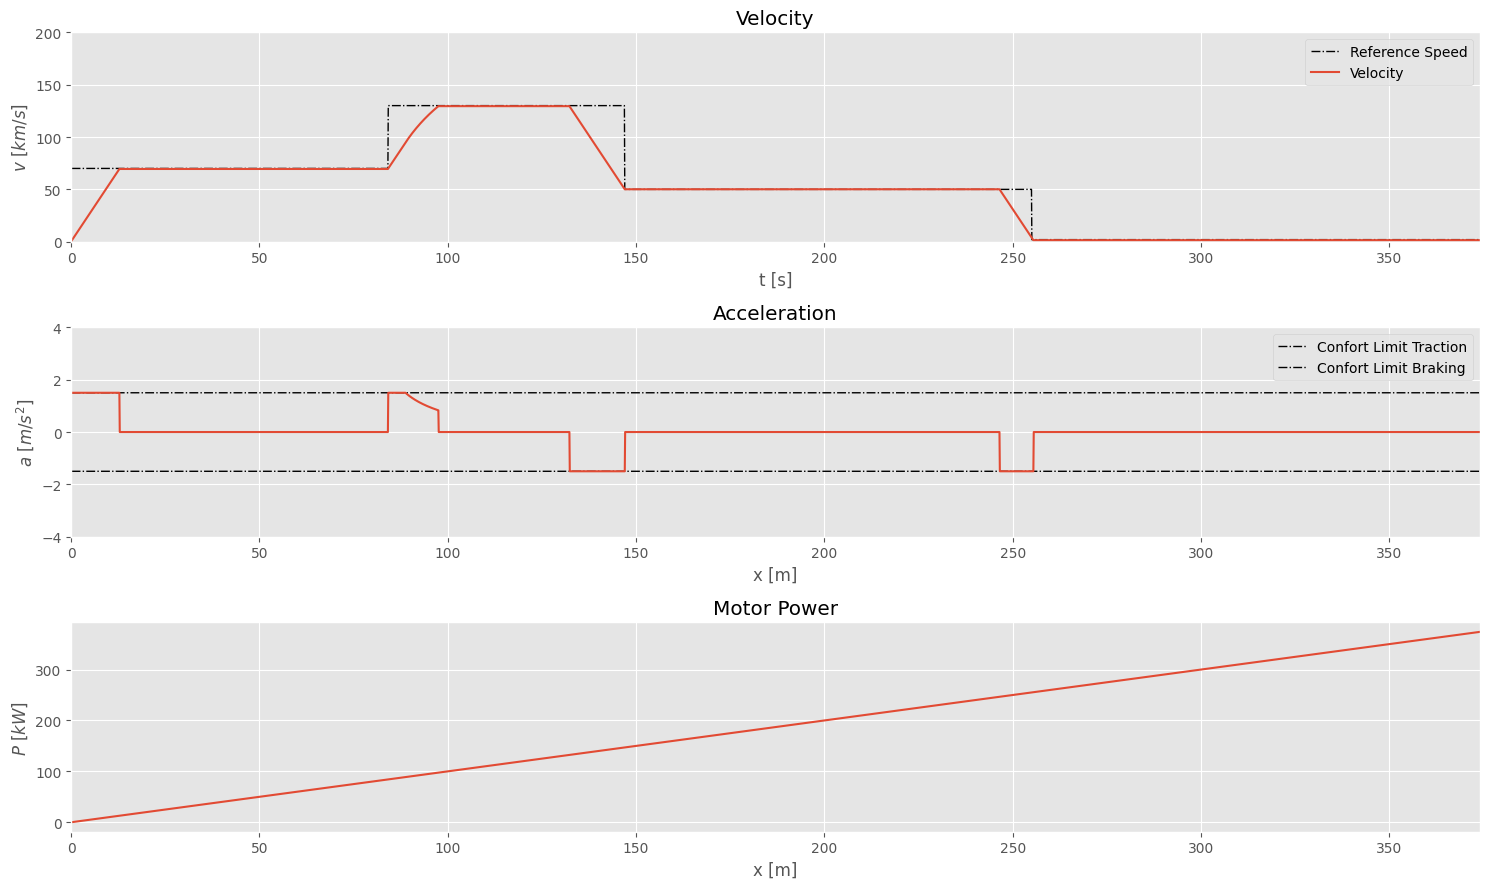

In [365]:
# Plot in t domain 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9))

ax1.plot(calc_t, calc_v_ref * 3.6, color='black', linestyle='-.', linewidth=1, label='Reference Speed')
ax1.plot(calc_t, calc_v * 3.6, label='Velocity')
ax1.set(
    title='Velocity',
    xlabel=r't [s]',
    ylabel=r'$v\ [km/s]$',
    ylim=(0, 200),
)
ax1.legend(loc='upper right')

ax2.plot(calc_t, np.full(len(calc_t), 1.5), color='black', linestyle='-.', linewidth=1, label='Confort Limit Traction')
ax2.plot(calc_t, np.full(len(calc_t), -1.5), color='black', linestyle='-.', linewidth=1, label='Confort Limit Braking')
ax2.plot(calc_t, calc_a)
ax2.set(
    title='Acceleration',
    xlabel=r'x [m]',
    ylabel=r'$a\ [m/s^2]$',
    ylim=(-4, 4),
)
ax2.legend(loc='upper right')

ax3.plot(calc_t, calc_p)
ax3.set(
    title='Motor Power',
    xlabel=r'x [m]',
    ylabel=r'$P\ [kW]$',

)
#ax3.legend(loc='upper right')


for ax in fig.get_axes():
    ax.set(
        xlim=(0, np.max(calc_t)),
        xticks=np.arange(0, 400, 50),
    )
plt.tight_layout()

plt.show()